# TIME SERIES ANALYSIS

# Goal: Find outliers, trends and periodicity in the MTA turnstile data
    

## DATA:
MTA subway fares. It is a complete dataset of
rides logged by card swipes for 600 Manhattan stations.

The data was organized  by Sina Kashuk at CUSP (he will teach the Geopanda lecture).
You can get it from the github repo (use the download link to download it live in your notebook). 
It contains 23 different subway card types 
(e.g. monthly pass, daily pass, Act for Disability pass…) as follows:


In [1]:
# from IPython.display import Image
# Image(filename = "Ridetypes.png")

## Each time series (per station, per ticket type) contains the number of swipes per week for 194 weeks from 05/21/2010 to 02/21/2014. 

The data are available to you as a *python data cube*. you can load it as 

```
np.load(“MTA_Fare.npy")
```

and you will end up with a python numpy array of 
shape (600, 23, 194)

## note that the missing values are inputted as -1

if you want to do things like algebra (summing time series for example) you need to take care of that. If you replace the -1 entries with NaN, you may need to use functions that explicitly know how to deal with NaN: for example, to sum use the no.nansum etc
```
np.nanmean(mtarides)
np.nansum(mtarides)
```


as opposed to just 

use the no.nansum etc
```
np.mean(mtarides)
np.sum(mtarides)
```

## Task 1: 
### Event detection: Identify the most prominent event. There is a very significant drop (>3-sigma) in all time series.
### Identify it, figure out the date (you know when the data starts and what the cadence is) and figure out what it is due to.


## Task 2: 
### Some of the time series are stationary, some have a complex structure, some show a downward trend: Identify the **ridership types**  that have steadily increased in popularity,  and that have steadily decreased. by how much? (e.g what is the ratio of usage in the first 10 and last 10 weeks)


## Task 3:
### Several stations show a prominent annual periodicity. Identify the 4 **stations** (indentify them by the index of their location in the data cube) that show the most prominent periodic trend on an annual period (52 weeks). (Can you figure out what the periodic peak in rides is due to?)


## EXTRA CREDIT: Cluster. 
### Cluster the time series, i.e. identify groups of time series that look similar among each other. You can use KMeans for example to identify common trends, or PCA (Principle Component Analysis). 
### Since this is extra credit I will leave it to you to figure out the details, but for KMeans for e.g. if you use the sklearn.cluster package it would look something like:

#i am flattening the first 2 dimensions of the cube to cluster all light curves for all stations and all types

```
tots = data.transpose(2,0,1).reshape(data.shape[2], data.shape[1]*data.shape[0]).T
```

#removing empty light curves
```
tots = tots[tots.std(1)>0]
```

#with Kmeans you have to choose the number of clusters ahead km = 

```
KMeans(n_clusters=10)
```

#and standardize the lightcurves before clustering. Notice: standardize, not whiten! If you have done clustering before you may have whitened the data: removed the variance by "column", here you want to remove the variance by "row". We will discuss this in the clustering lecture. 
```
vals = ((tots.T - tots.mean(1))/tots.std(1)).T
```

#then you can run:

```
km.fit(vals)
```

### Task 1:
Event detection: Identify the most prominent event. There is a very significant drop (>3-sigma) in all time series.
Identify it, figure out the date (you know when the data starts and what the cadence is) and figure out what it is due to.

In [41]:
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from scipy.spatial.distance import cdist, pdist
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans
plt.style.use("ggplot")
%matplotlib inline

In [3]:
mtarides = np.load(os.getenv("PUIDATA") + "/MTA_Fare.npy").astype(float)
type(mtarides)

numpy.ndarray

In [4]:
mtarides.shape


(600, 23, 194)

In [5]:
mtarides.flatten().shape

(2677200,)

In [6]:
mtarides[mtarides == -1] = np.nan


In [7]:
mtarides[0][22]

array([   nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
          nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
          nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
          nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
          nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
          nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
          nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
          nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
          nan,    nan,    nan,  3214.,  3333.,  2604.,  3392.,  2955.,
        3423.,  3469.,  2705.,  2644.,  3391.,  2311.,  3511.,  3336.,
        3583.,  3652.,  1268.,  2739.,  3479.,  2926.,  2342.,  2858.,
        3756.,  3298.,  1398.,  3392.,  3450.,  3448.,  3465.,  3351.,
        2890.,  1539.,  3356.,  3496.,  3528.,  3437.,  3554.,  3492.,
        2938.,  2898.,     0.,     0.,     0.,     0.,     0.,     0.,
      

In [8]:
daterg = pd.date_range("05/21/2010","02/21/2014", freq="w")
daterg

DatetimeIndex(['2010-05-23', '2010-05-30', '2010-06-06', '2010-06-13',
               '2010-06-20', '2010-06-27', '2010-07-04', '2010-07-11',
               '2010-07-18', '2010-07-25',
               ...
               '2013-12-15', '2013-12-22', '2013-12-29', '2014-01-05',
               '2014-01-12', '2014-01-19', '2014-01-26', '2014-02-02',
               '2014-02-09', '2014-02-16'],
              dtype='datetime64[ns]', length=196, freq='W-SUN')

In [9]:
def findevent(data):
    """Find the significant drop (>3-sigma) in all time series.
    Keyword arguments:
    data -- numpy.ndarray
    
    """
    datamean = np.nanmean(data)
    datastdv = np.nanstd(data)
    date = np.where((data > datamean + 3 * datastdv) | (data < datamean - 3 * datastdv))
    return date
    

In [10]:
mtaridestation = np.nanmean(mtarides, axis = 0)
#findevent(mtarides)


/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


In [11]:
eventday = daterg[findevent(np.nanmean(mtaridestation, axis = 0))[0][0] + 1]
eventday

Timestamp('2012-10-28 00:00:00', offset='W-SUN')

In [12]:
print 'The most prominent event happened on %s-%s-%s' %(eventday.year, eventday.month, eventday.day)

The most prominent event happened on 2012-10-28


### By searching '2012-10-28 NYC', the result shows Hurricane_Sandy came to NY and MTA stopped so that citizens did not travel a lot during that time period. 

MTA Prepares for Hurricane Sandy
http://www.mta.info/news/2012/10/26/mta-prepares-hurricane-sandy

Hurricane Sandy - Wikipedia
https://en.wikipedia.org/wiki/Hurricane_Sandy

### Task 2:
Some of the time series are stationary, some have a complex structure, some show a downward trend: Identify the ridership types that have steadily increased in popularity, and that have steadily decreased. by how much? (e.g what is the ratio of usage in the first 10 and last 10 weeks)


In [13]:
ridetype = np.array(['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp','ez',
            'ff','mc','mr','month','rfm','rr','sen','spec','tcmc','t',
            'umlim','xbus','stud'])


/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version
  app.launch_new_instance()
/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "
/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


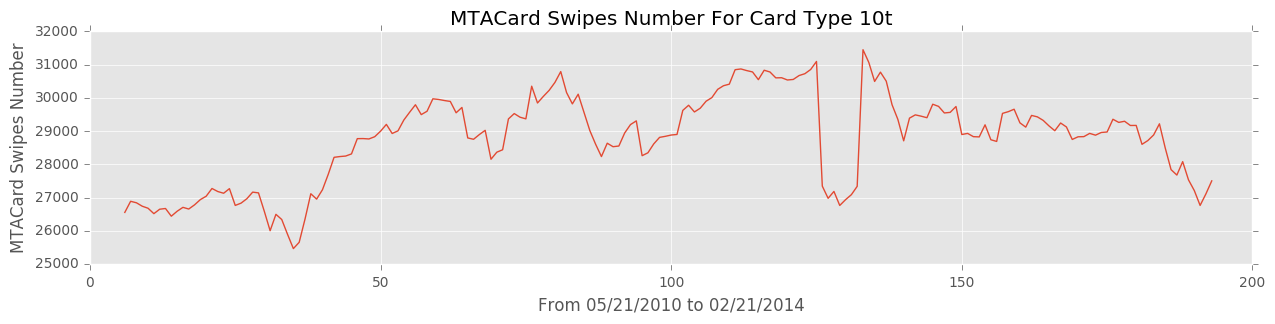

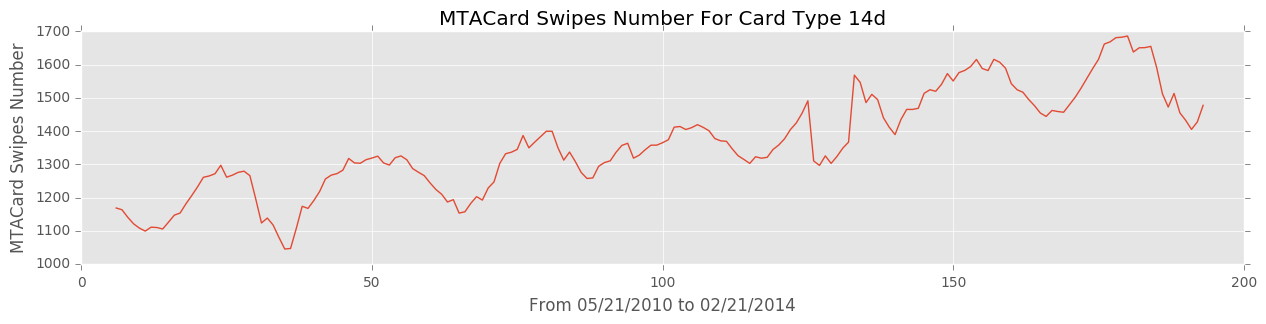

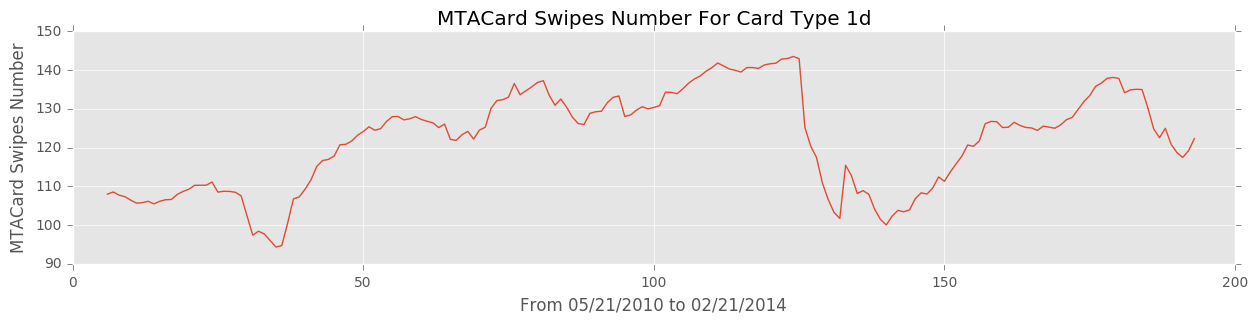

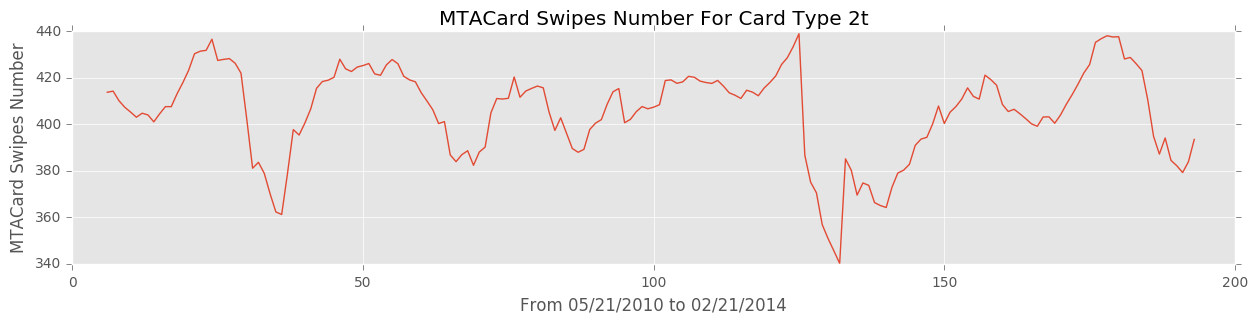

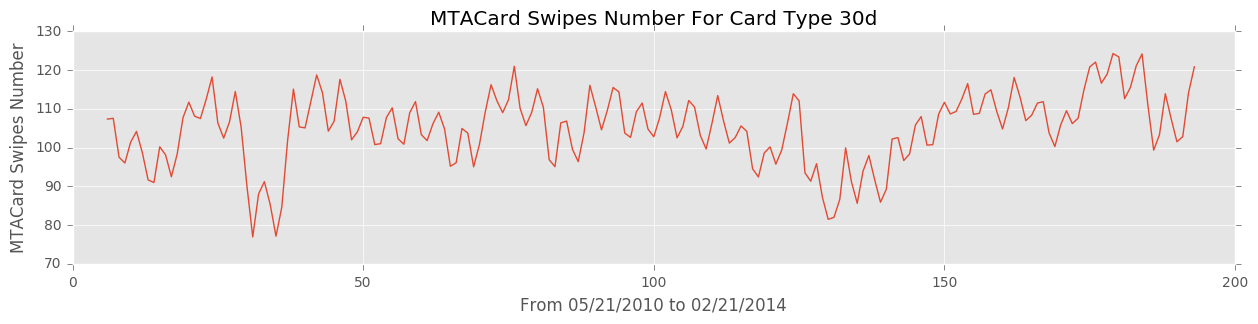

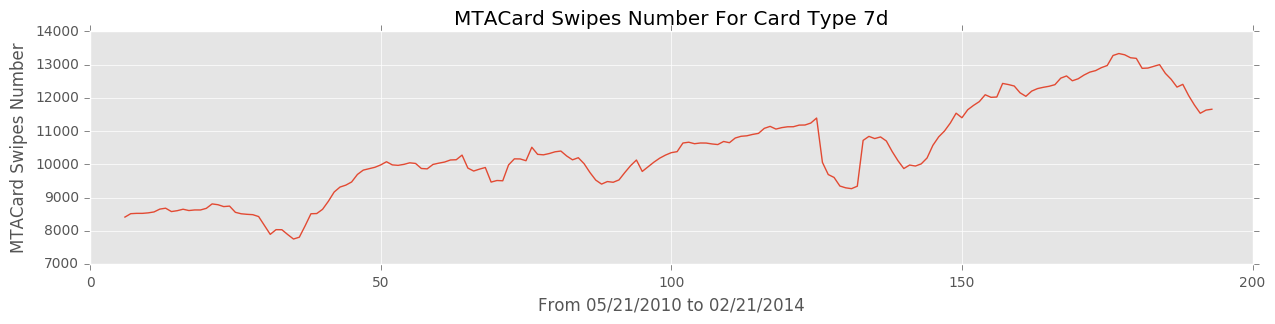

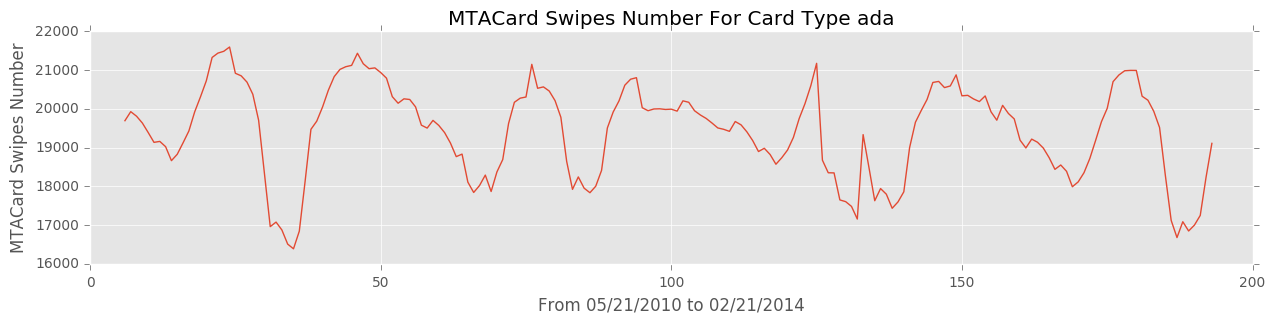

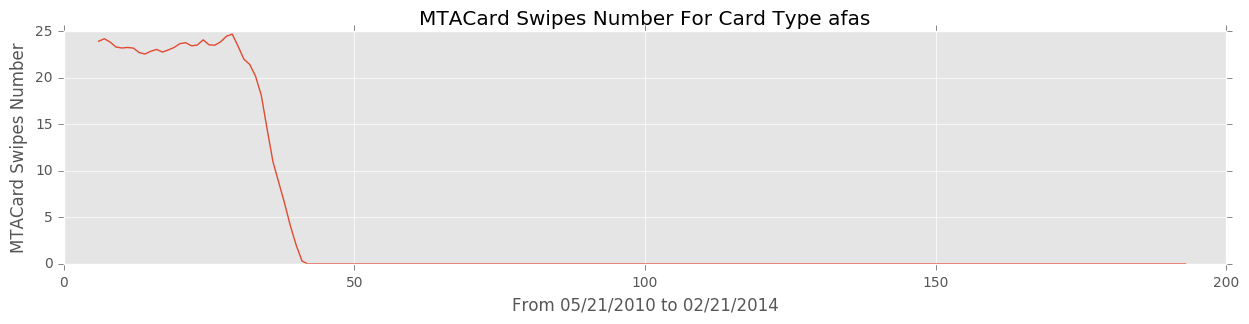

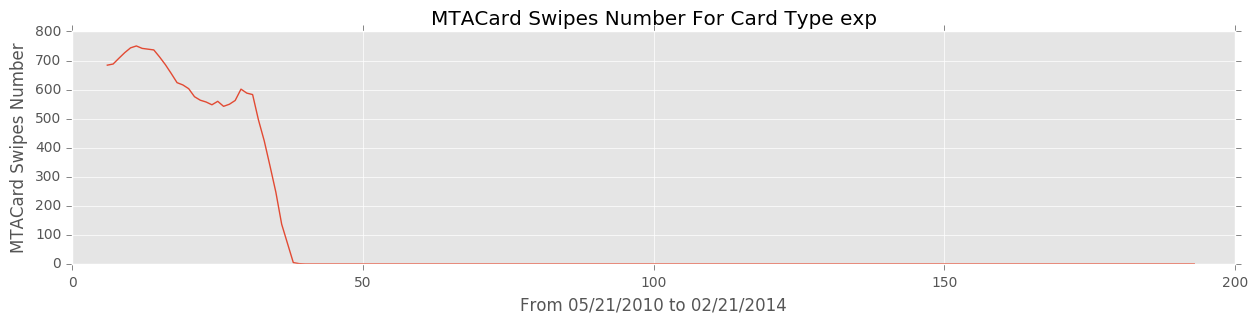

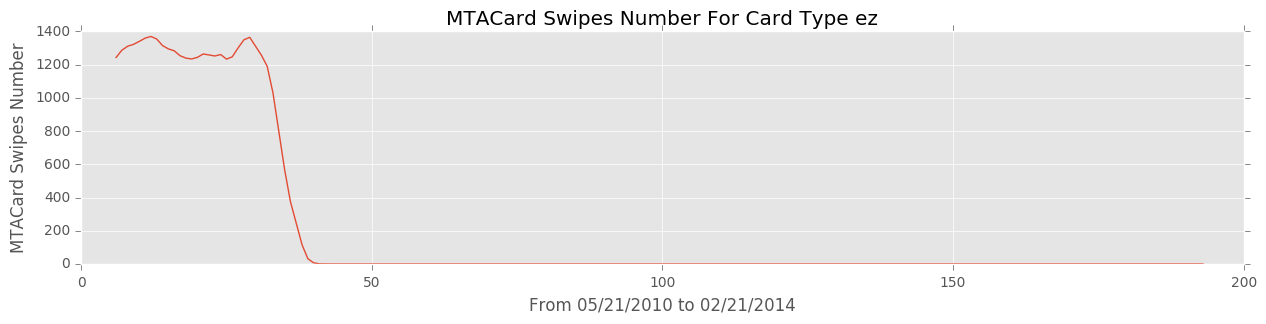

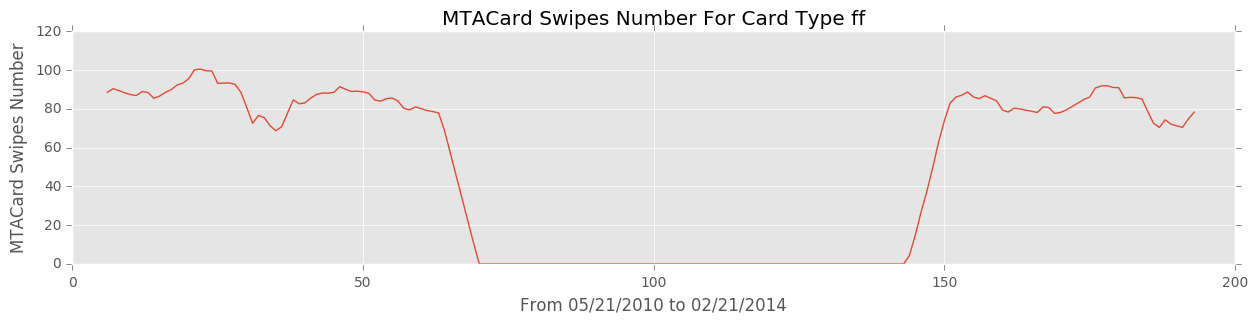

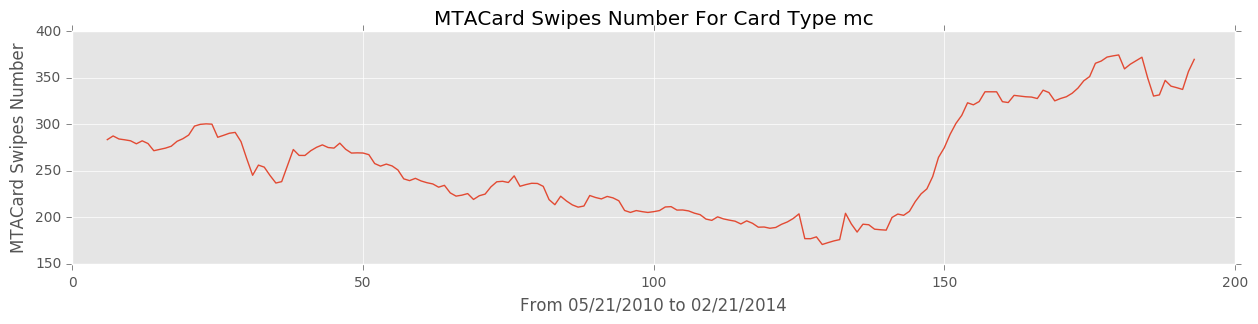

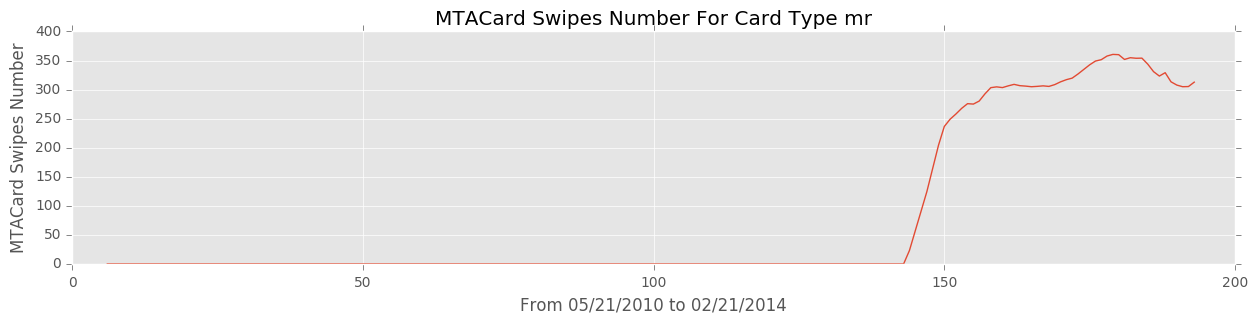

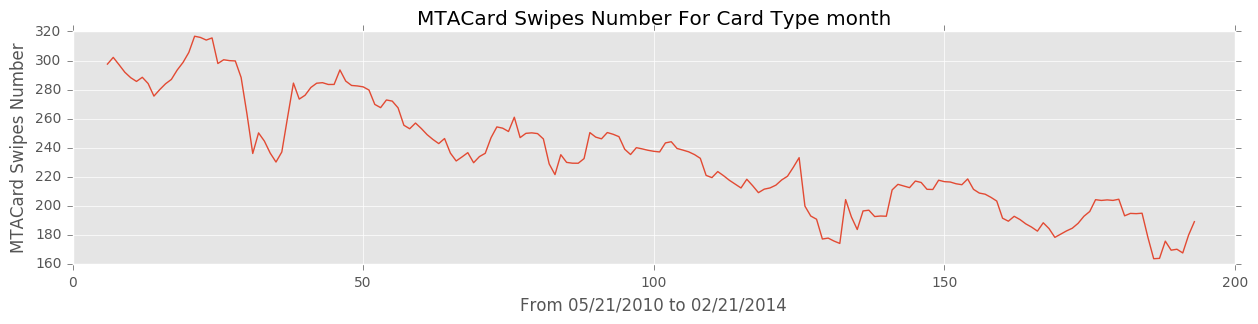

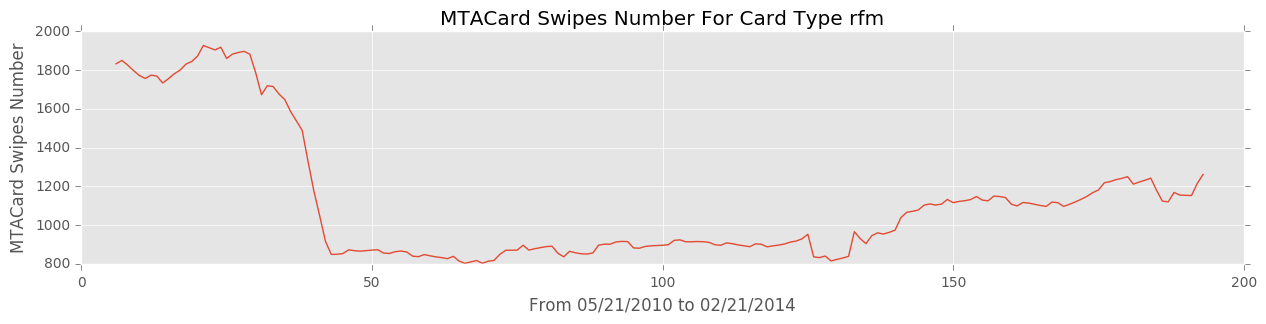

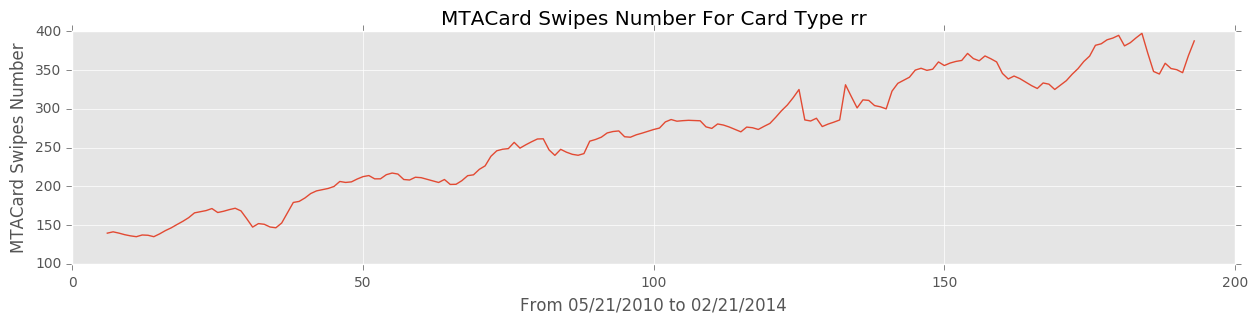

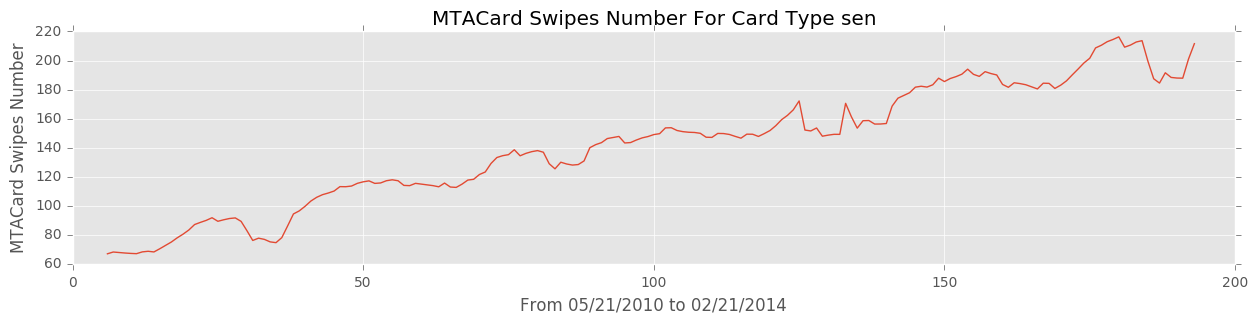

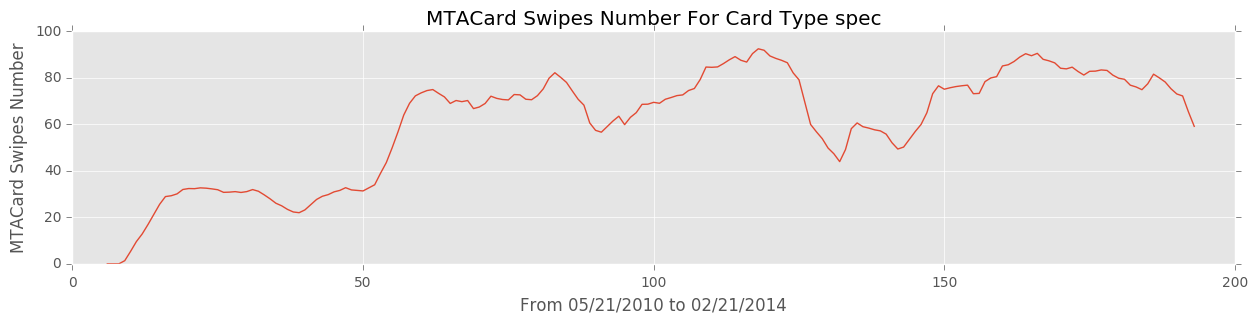

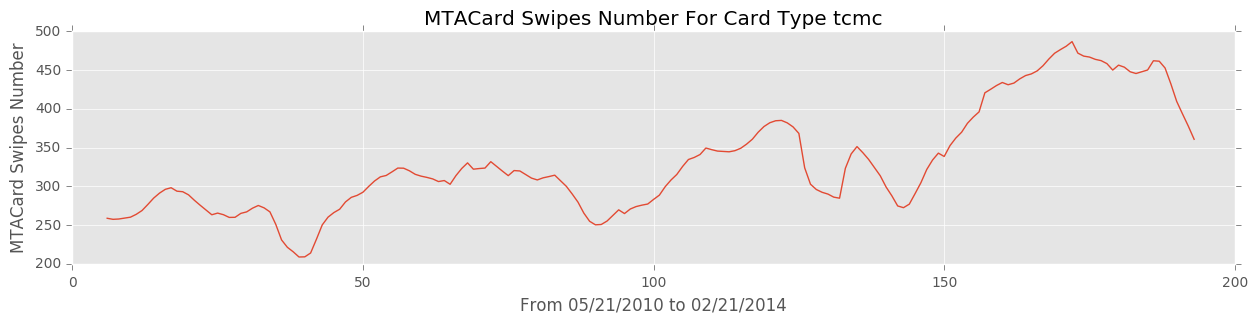

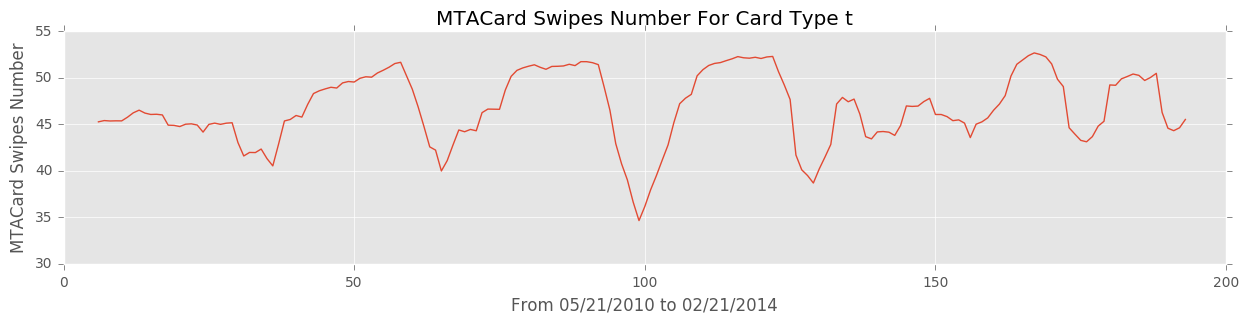

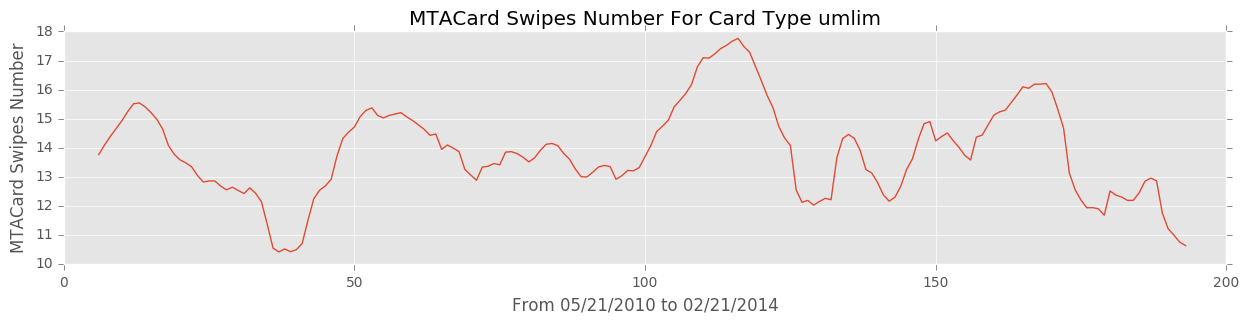

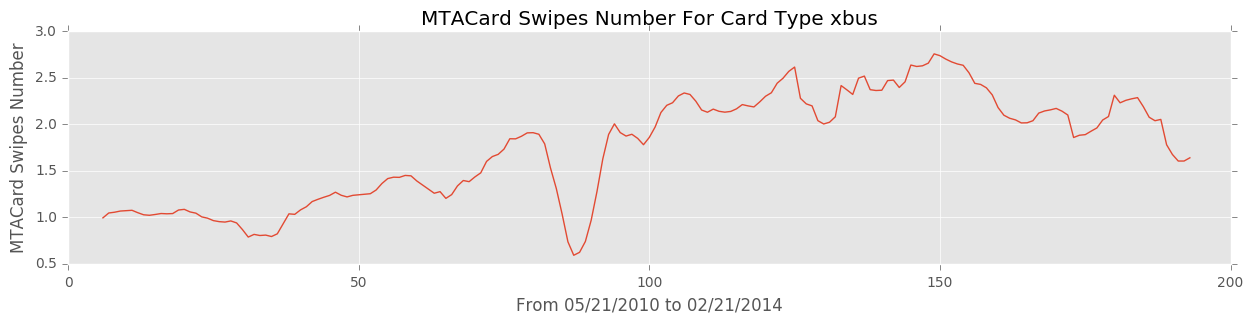

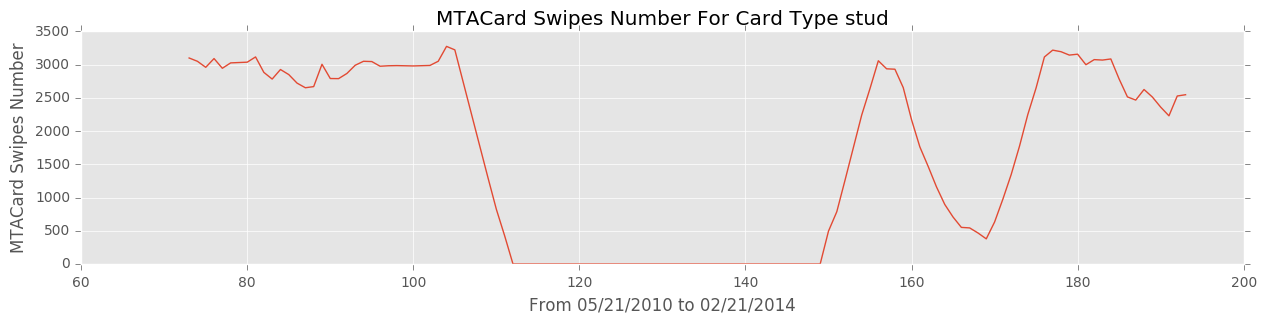

In [14]:
for i in range (0,23):
    fig = plt.figure(figsize=(15,3))
    plt.plot(pd.rolling_mean(np.nanmean(mtarides, axis = 0)[i,:],7))
    plt.title("MTACard Swipes Number For Card Type %s" %(ridetype[i]))
    plt.xlabel("From 05/21/2010 to 02/21/2014")
    plt.ylabel("MTACard Swipes Number")
    plt.legend(loc="perfect")

### Identify the ridership types that have steadily increased in popularity, and that have steadily decreased. 

The ridership types that have steadily increased in popularity: 14d, 7d, rr, sen, tcmc

The ridership types that have steadily decreased in popularity: month

### by how much? (e.g what is the ratio of usage in the first 10 and last 10 weeks)

In [15]:
a = [[2,3,4],[2,3],[6,7,8]]
np.nansum(a[2][-2:])

15

In [16]:
mtarship = np.nanmean(mtarides, axis=1)
first10 = 0
last10 = 0
for i in range(23):
    first10 = np.nansum((mtarship[i][:10]))
    last10 = np.nansum((mtarship[i][-10:]))
    r = (last10 - first10)/first10
    print 'he ratio of usage in the first 10 and last 10 weeks for rider type %s is %.2f' %(ridetype[i], r*100) +'%'
 
    

he ratio of usage in the first 10 and last 10 weeks for rider type 10t is -50.39%
he ratio of usage in the first 10 and last 10 weeks for rider type 14d is -100.00%
he ratio of usage in the first 10 and last 10 weeks for rider type 1d is 13.48%
he ratio of usage in the first 10 and last 10 weeks for rider type 2t is 26.28%
he ratio of usage in the first 10 and last 10 weeks for rider type 30d is 14.79%
he ratio of usage in the first 10 and last 10 weeks for rider type 7d is 19.69%
he ratio of usage in the first 10 and last 10 weeks for rider type ada is 10.67%
he ratio of usage in the first 10 and last 10 weeks for rider type afas is 21.17%
he ratio of usage in the first 10 and last 10 weeks for rider type exp is 18.89%
he ratio of usage in the first 10 and last 10 weeks for rider type ez is 27.25%
he ratio of usage in the first 10 and last 10 weeks for rider type ff is 0.78%
he ratio of usage in the first 10 and last 10 weeks for rider type mc is -1.72%
he ratio of usage in the first 

#### For the ridership types that have steadily increased in popularity, the ratio of usage in the first 10 and last 10 weeks are:

!!!Must be wrong....

1.14d: 100.00%

2.7d: 19.69%

3.rr: 0.88%

4.sen: 10.33%

5.tcmc: 8.78%

#### For the ridership types that have steadilyncreased in popularity, the ratio of usage in the first 10 and last 10 weeks is:
month: 13.51%

### Task 3:
Several stations show a prominent annual periodicity. Identify the 4 stations (indentify them by the index of their location in the data cube) that show the most prominent periodic trend on an annual period (52 weeks). (Can you figure out what the periodic peak in rides is due to?

In [17]:
len(mtarship)

600

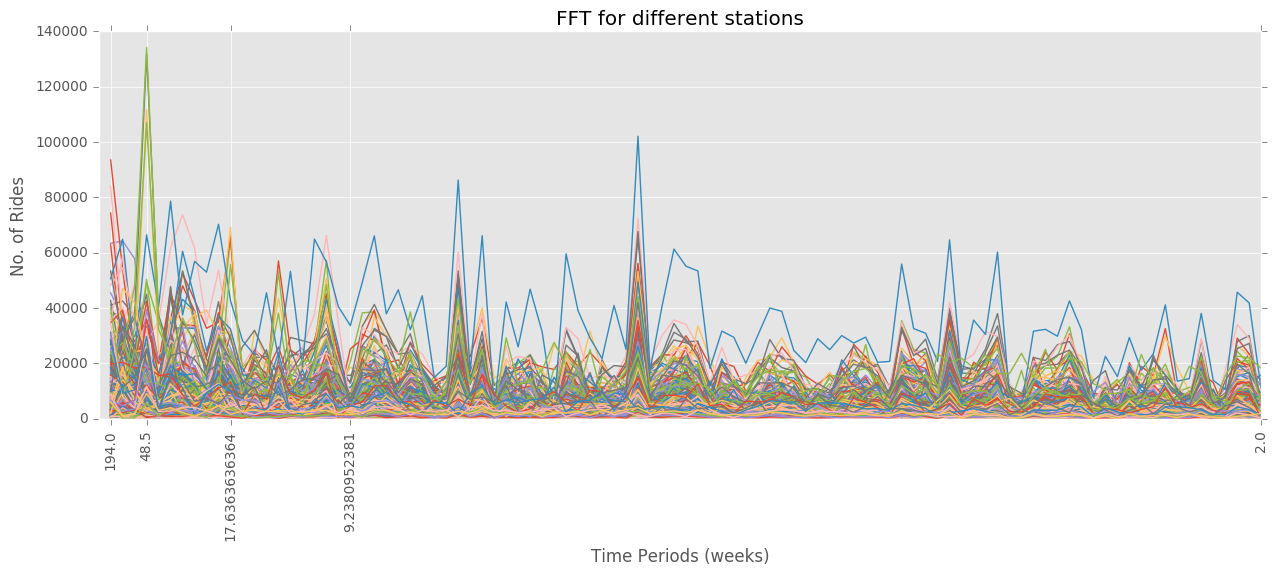

In [18]:
# this is a "power spectrum": the plot of the absolute value of the fourier transform. 
# I changed the xtick labels from frequecy (1/week) to period (in weeks)
# to facilitate the visual identification of the 1-year period peak
# (notice however that np.fft.rfftfreq(N, d)  returns frequency, the inverse of the period: frequency = 1/period. 
# All I did was changing the tick labels): 
fig=plt.figure(figsize=(15,5))
peak = []
for i in range(600):
    f = np.abs(np.fft.rfft(mtarship[i,:]))[1:]
    ax=fig.add_subplot(111)
    periods = np.fft.rfftfreq(mtarship[i,:].shape[0], 1)[1:]
    peak.append(f[3])
    ax.plot(periods, f)
allperiods = periods[[0, 3, 10, 20, -1]]
ax.set_xticks(allperiods)
ax.set_xticklabels(["%s"%(1/f) for f in allperiods], rotation=90)
ax.set_xlabel("Time Periods (weeks)")
ax.set_ylabel("No. of Rides")
ax.set_title("FFT for different stations")
#(np.fft.rfft(mtastation[i,:])


 
#ax.set_xticklabels([ "%s"%(1/f) for f in allperiods], rotation=90)

In [32]:
type(peak)

peak = np.array(peak)

In [33]:
peaksort = np.argsort(peak)[::-1]

In [34]:
peaksort

array([599, 468, 477, 476, 475, 474, 473, 472, 471, 470, 469, 467, 479,
       466, 465, 464, 463, 458, 457, 456, 429, 426, 478, 480, 417, 492,
       501, 500, 499, 498, 497, 496, 495, 494, 493, 491, 481, 490, 489,
       488, 487, 486, 485, 484, 483, 482, 418, 416, 503,  77, 244, 226,
       171, 161, 124, 119, 105,  87,  86,  76, 258,  75,  74,  73,  72,
        71,  70,  25,  14,   1, 256, 269, 415, 356, 414, 412, 409, 400,
       399, 387, 381, 369, 357, 350, 284, 345, 337, 336, 335, 334, 324,
       305, 304, 598, 502,   0, 504, 560, 559, 584, 585, 586, 558, 557,
       587, 588, 589, 556, 590, 591, 554, 553, 552, 551, 592, 593, 594,
       549, 548, 583, 582, 596, 561, 571, 572, 570, 573, 574, 575, 569,
       568, 567, 566, 576, 577, 505, 578, 565, 579, 564, 563, 562, 580,
       581, 595, 555, 531, 528, 537, 547, 523, 546, 524, 525, 526, 527,
       529, 520, 530, 543, 532, 533, 542, 597, 536, 539, 521, 522, 519,
       514, 506, 507, 508, 509, 510, 511, 512, 513, 515, 516, 51

In [35]:
mask = np.where(~np.isnan(peak[peaksort]))[0]
stations = peaksort[mask][:4]
print 'The 4 stations with the most prominent periodic are: %s' %(stations)

The 4 stations with the most prominent periodic are: [194 150  32 327]


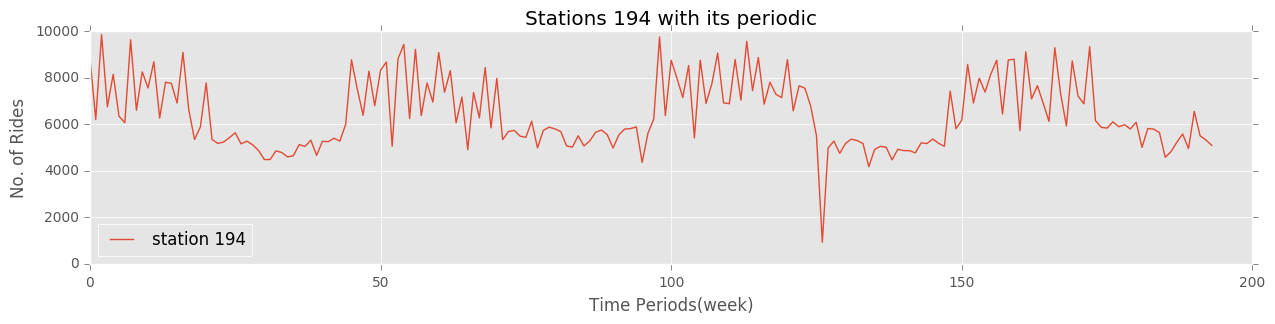

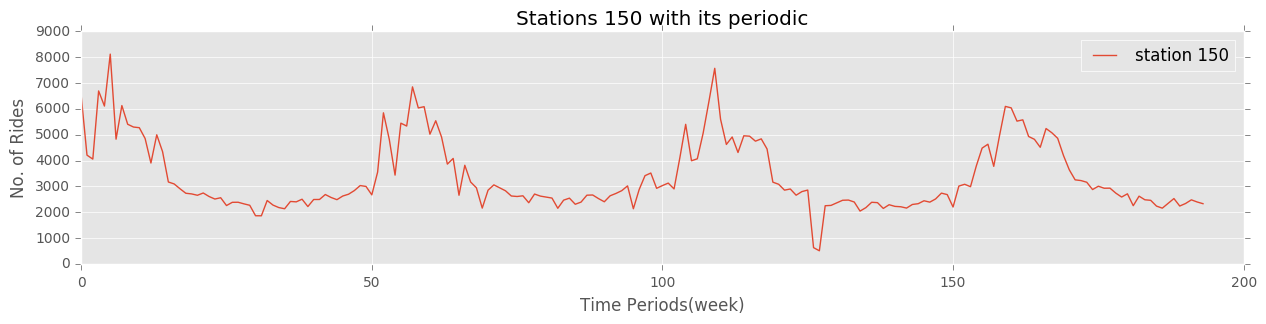

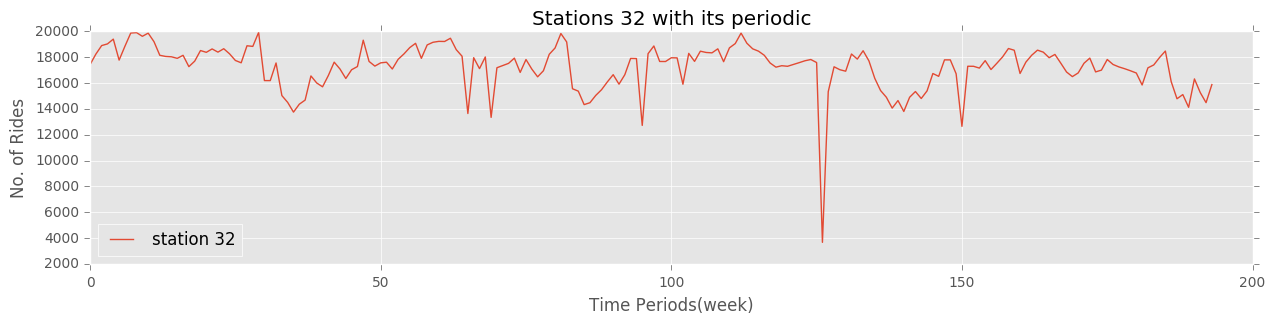

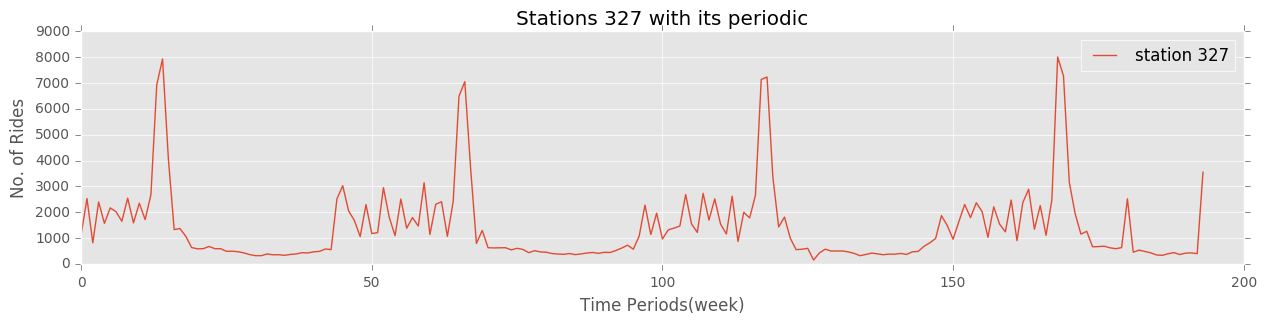

In [36]:
for i in stations:
    fig = plt.figure(figsize=(15,3))
    plt.plot(mtarship[i], label = "station "+str(i))
    plt.title("Stations %s with its periodic" %i)
    plt.ylabel("No. of Rides")
    plt.xlabel("Time Periods(week)")
    plt.legend(loc = "best")

### Chooes the data between 20 -80 as expamle, for the 4 stations above, the number of riders increase during the week 40 - 60 (week 0 is 5/21)which is almost the summer time, and drop during winter, so it may because there are parks pr gardens near those stations and people love to go there during summer.


### EXTRA CREDIT: Cluster.
Cluster the time series, i.e. identify groups of time series that look similar among each other. You can use KMeans for example to identify common trends, or PCA (Principle Component Analysis).


In [45]:
tots = mtarides.transpose(2,0,1).reshape(mtarides.shape[2], mtarides.shape[1]*mtarides.shape[0]).T
#removing empty light curves
tots = tots[tots.std(1)>0]

#and standardize the lightcurves before clustering. Notice: standardize, not whiten! 
#If you have done clustering before you may have whitened the data: removed the variance by "column",
#here you want to remove the variance by "row". We will discuss this in the clustering lecture.
vals = ((tots.T - tots.mean(1))/tots.std(1)).T


### Using Elbow Method to find the number of cluster

In [38]:
def elbow(data,K):
#data is your input as numpy form
#K is a list of number of clusters you would like to show.
    # Run the KMeans model and save all the results for each number of clusters
    KM = [KMeans(n_clusters=k).fit(data) for k in K]
    
    # Save the centroids for each model with a increasing k
    centroids = [k.cluster_centers_ for k in KM]

    # For each k, get the distance between the data with each center. 
    D_k = [cdist(data, cent, 'euclidean') for cent in centroids]
    
    # But we only need the distance to the nearest centroid since we only calculate dist(x,ci) for its own cluster.
    globals()['dist'] = [np.min(D,axis=1) for D in D_k]
    
    # Calculate the Average SSE.
    avgWithinSS = [sum(d)/data.shape[0] for d in dist]
    
    
    # elbow curve
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(K, avgWithinSS, 'b*-')
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('Average within-cluster sum of squares')
    plt.title('Elbow for KMeans clustering')
    plt.show()
    
    
    # Total with-in sum of square plot. Another way to show the result.
    wcss = [sum(d**2) for d in dist]
    tss = sum(pdist(data)**2)/data.shape[0]
    bss = tss-wcss
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(K, bss/tss*100, 'b*-')
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('Percentage of variance explained')
    plt.title('Elbow for KMeans clustering')
    plt.show()

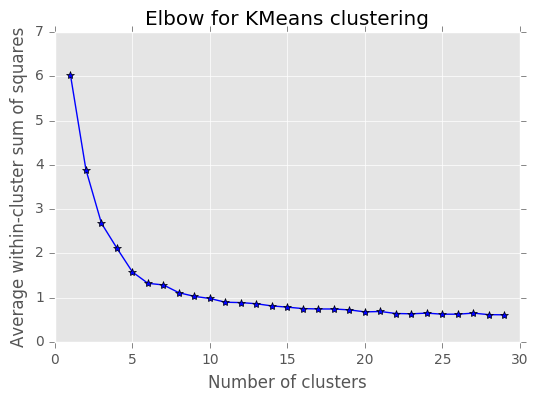

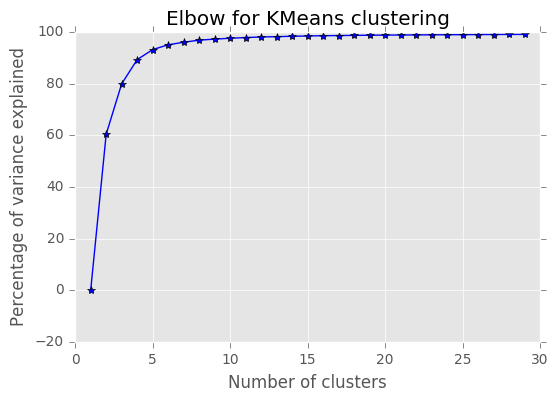

In [46]:
elbow(tots_std, range(1,30))

### From the figs above we can see when number of clusters is around 5, the sum of squared error (the sum of the squared distance between each member of the cluster and its centroid) decreases abruptly. So the number of clusters is around 5

In [53]:
#with Kmeans you have to choose the number of clusters ahead
km =KMeans(n_clusters=5)

#then you can run:
km.fit(vals)
n=5 # number of clusters
dd=vals #data

km=KMeans(n_clusters=n)
res=km.fit(dd)

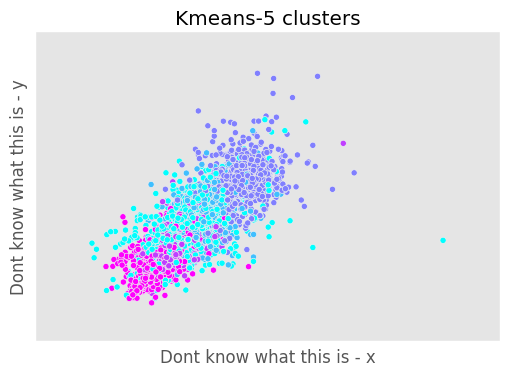

In [55]:
#plt.subplot(1,3,3)
plt.scatter(dd[:, 0], dd[:, 1], c=res.labels_, cmap=plt.cm.cool)
plt.xlabel('Dont know what this is - x')
plt.ylabel('Dont know what this is - y')
plt.xticks(())
plt.yticks(())
plt.title("Kmeans-{} clusters".format(n))
plt.show()

# HINTS: 


## There are 600 stations, 23 card types. The trick to do this homework succesfully is to "collaps" (by averaging, or summing, dependingon the question) the appropriate dimension in different parts of the homework: when you need to work on the station level, collaps the card type, when you need to work on the card type, collapse the stations. 

When I ask you "which station ...", you can sum or average over the ridership types for all station and reduce your data by a factor 23. When I ask you "which rideship type ..." you can sum or average over the stations and reduce your data by a factor 600! (or even better you could take a weighted average). The sum and average functions take an "axis" argument, which allows you to control which axis of the cube gets averaged. The dimension of the resulting object will allow you to check that you averaged over the dight axis.


# Possibly useful functions

I  used a variety of functions, most of them you are familiar with already. here are a few that you may not have encountered yet which I used. You do not have to use them: there are many ways to do things and you do not have to solve this problem like I did, but here they are in case you need some help:

* the numpy function np.where() returns the index where a condition is true. It is slow and inefficient but very intuitive and convenient


* the nupy functions np.nansum(), np.sum(), np.nanmean() etc take an array and the axis along which to sum as inputs. If you want to sum over stations, or over rides, you can use these passing the appropriate axis number: axis=1 axis=2...


* to find periodicity you can use fourier transforms. Look at the notebook on fourier transforms in https://github.com/fedhere/UInotebooks/tree/master/timeseries. If you choose to use the numpy package you may want to use the real fft function:  np.fft.rfft  
```
np.fft.rfft(mydata) 
```  

    will return the *real* part of the fourier transform (which is a *complex* object, and therefore it has a real and an *imaginary* component - that is just math. All you need to know is that you need the real part). But what you want is its absolute value: np.abs(). Then to get the x axis of your plot in frequency (1/week since the data is in weeks) you can use the function 

```
np.fft.rfftfreq(N, d) 
```     
     which takes as arguments N = the length of your time series (the number of datapoints) and d: the *sample spacing*, or 1.0/sampling_rate (in this case, with 1/week sampling, if you want the freq in units of week that is just 1!)


*  the 
```
np.array.flatten()
np.array.reshape()
```
    array methods allow you to manipulate the shape of an array, for example if you want to run analysis on each individual time series, each station and each ridership type, which i recommand if you want to work on clustering for extra credit (resulting into 600*23=13800 time series) you can flatten the array as
```
mtaarray.flatten()
```

    which returns the flatten array:

```
mtaRides = np.load("MTA_Fare.npy")

mtaRides.shape
Out[10]: (600, 23, 194)

mtaRides.flatten().shape
Out[11]: (2677200,)
````



In [ ]:
#after reading the datacube you should see:
mtarides.shape


ride types list

In [ ]:
ridetype = np.array(['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp','ez',
            'ff','mc','mr','month','rfm','rr','sen','spec','tcmc','t',
            'umlim','xbus','stud'])

In [ ]:
#after that I create a date range (for example with pd.date_range())
#in a log plot to enhance the visibility along the y axis (np.log10(weightedrides[i]))
#all time series, each station each ride type, look like this (pretty ugly)

In [ ]:
#as described in the instruction for some of the analysis 
#one can sum time series for all stations
print (mtarides.shape)
mta_allsum = np.nansum(mtarides, axis=0)
print (mta_allsum.shape)
#or for all ride types
mta_allsum = np.nansum(mtarides, axis=1)
print (mta_allsum.shape)



## NOTE ON THE TREND DETECTION:
### you should find the *card type* that has the steepest increase, and the steepest decrease. Notice: we are looking for something that has a more or less constant trend

### to do this you can sum or average (a weighted average is probably best) over all stations, leaving you with 23 time series, one per ridership type. 

### you can use a rolling mean for smoothing (pd.rolling_mean() for example), and you can calculate the ratio of the *number of rides* near the beginning to the *number of rides* near the end of the time series.

### notice that you should inspect the time series, algorithmically or at least by eye, to ensure you see a trend, and not just changing structure. Below is an example of a lightcurve with structure (top) and a lightcurve with a constant trend (bottom) both showing a large deviation between the beginning and the end of the time series

to determine if there is a trend or strucutre you can inspect the time series visually, since there are only 23!
an alternative, algorithmic way to do it, is to fit a line to the (smoothed) time series  and look at the residuals.

In [ ]:
#here is an example of an individual time series that shows a trend, 
#after smoothing by 3 and 10 weeks

In [ ]:
# this is a "power spectrum": the plot of the absolute value of the fourier transform. 
# I changed the xtick labels from frequecy (1/week) to period (in weeks)
# to facilitate the visual identification of the 1-year period peak
# (notice however that np.fft.rfftfreq(N, d)  returns frequency, the inverse of the period: frequency = 1/period. 
# All I did was changing the tick labels): 





ax.set_xticklabels([ "%s"%(1/f) for f in allperiods], rotation=90)

In [ ]:
#and here is one of he periodic time series you should find by identifying the time series with the most power 
#at 1/52 weeks frequency in fourier space